# Container Damaged/Undamaged State - Exploratory Data Analysis and Machine Learning Models

### Importing Necessary Libraries

In [3]:

import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier

sns.set_theme(style="whitegrid", context="notebook")

In [4]:
FILE  = "ML Verileri.xlsx"
SHEET = "Hasar Durumu"

df = pd.read_excel(FILE, sheet_name=SHEET)


In [5]:
df.head()

,MÜŞTERİ,GOODS,KONTEYNER YAŞI,GEÇMİŞ HASAR ADEDİ,TAŞIMA ARACI,Hasar Durumu
0,Zresh,Fresh Produce,7,4,Kamyon,Hasarlı
1,BESLER/Eski Kerevitaş,Yağ,14,2,Demiryolu,Hasarlı
2,FEAST(OZGORKEY),Horeca and Patisserie,14,2,Kamyon,Hasarsız
3,BESLER/Eski Kerevitaş,Yağ,7,3,Demiryolu,Hasarlı
4,Corex,Pasta and Legumes,8,3,Kamyon,Hasarsız


### Datatype control and transformations

In [6]:
df["Hasar Durumu"] = df["Hasar Durumu"].astype(str).str.strip()
df["y_bin"] = (df["Hasar Durumu"].str.lower() == "hasarlı").astype(int)  # 1=Hasarlı, 0=Hasarsız

# Numeric safety
df["KONTEYNER YAŞI"]       = pd.to_numeric(df["KONTEYNER YAŞI"], errors="coerce")
df["GEÇMİŞ HASAR ADEDİ"]   = pd.to_numeric(df["GEÇMİŞ HASAR ADEDİ"], errors="coerce")


In [7]:
df.head()

,MÜŞTERİ,GOODS,KONTEYNER YAŞI,GEÇMİŞ HASAR ADEDİ,TAŞIMA ARACI,Hasar Durumu,y_bin
0,Zresh,Fresh Produce,7,4,Kamyon,Hasarlı,1
1,BESLER/Eski Kerevitaş,Yağ,14,2,Demiryolu,Hasarlı,1
2,FEAST(OZGORKEY),Horeca and Patisserie,14,2,Kamyon,Hasarsız,0
3,BESLER/Eski Kerevitaş,Yağ,7,3,Demiryolu,Hasarlı,1
4,Corex,Pasta and Legumes,8,3,Kamyon,Hasarsız,0


## Exploratory Data Analysis

### Target distribution

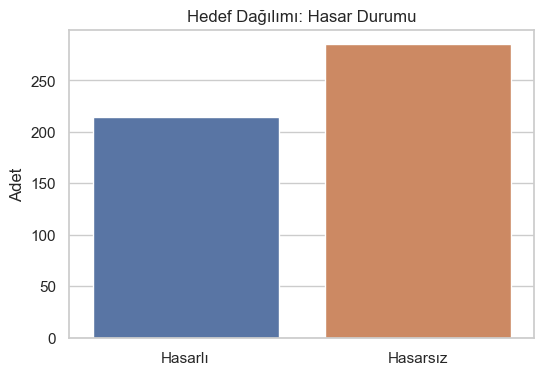

Hasarlı oranı: 43.0%


In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x="Hasar Durumu", data=df)
plt.title("Hedef Dağılımı: Hasar Durumu")
plt.ylabel("Adet"); plt.xlabel("")
plt.show()
# Sınıf oranı
print("Hasarlı oranı: %.1f%%" % (df["y_bin"].mean()*100.0))

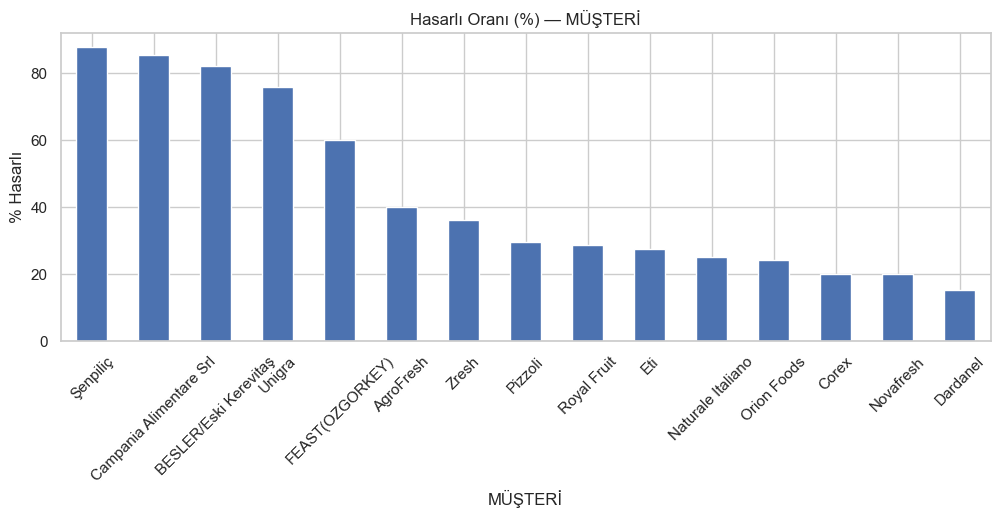

,count,mean
MÜŞTERİ,,
Şenpiliç,32,0.875000
Campania Alimentare Srl,27,0.851852
BESLER/Eski Kerevitaş,33,0.818182
Unigra,33,0.757576
FEAST(OZGORKEY),35,0.600000
AgroFresh,45,0.400000
Zresh,39,0.358974
Pizzoli,34,0.294118
Royal Fruit,21,0.285714


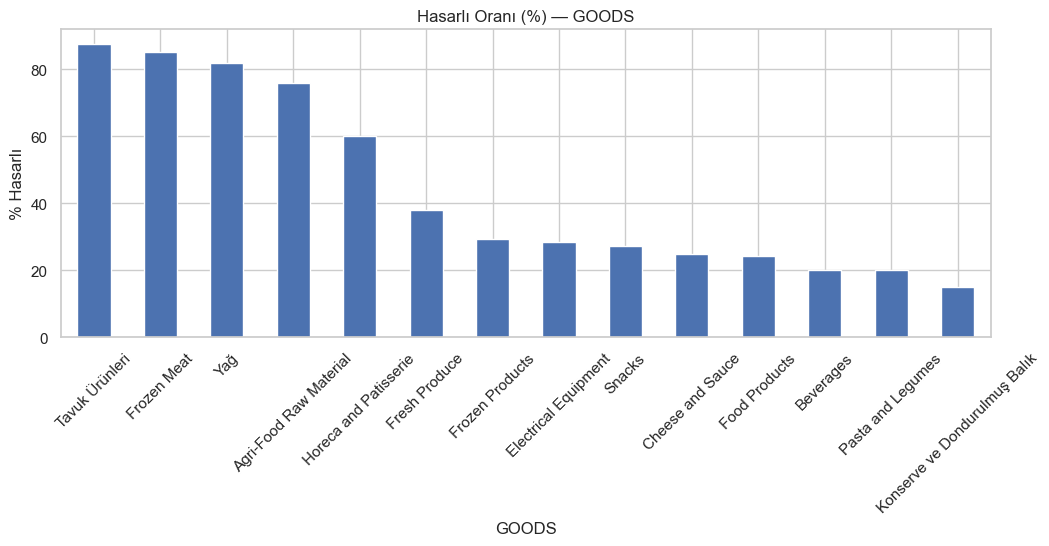

,count,mean
GOODS,,
Tavuk Ürünleri,32,0.875000
Frozen Meat,27,0.851852
Yağ,33,0.818182
Agri-Food Raw Material,33,0.757576
Horeca and Patisserie,35,0.600000
Fresh Produce,84,0.380952
Frozen Products,34,0.294118
Electrical Equipment,21,0.285714
Snacks,22,0.272727


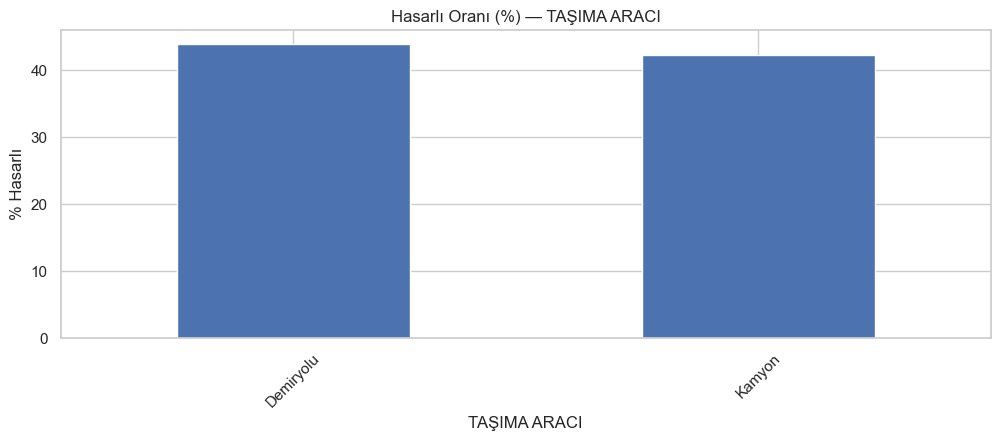

,count,mean
TAŞIMA ARACI,,
Demiryolu,251,0.438247
Kamyon,249,0.421687


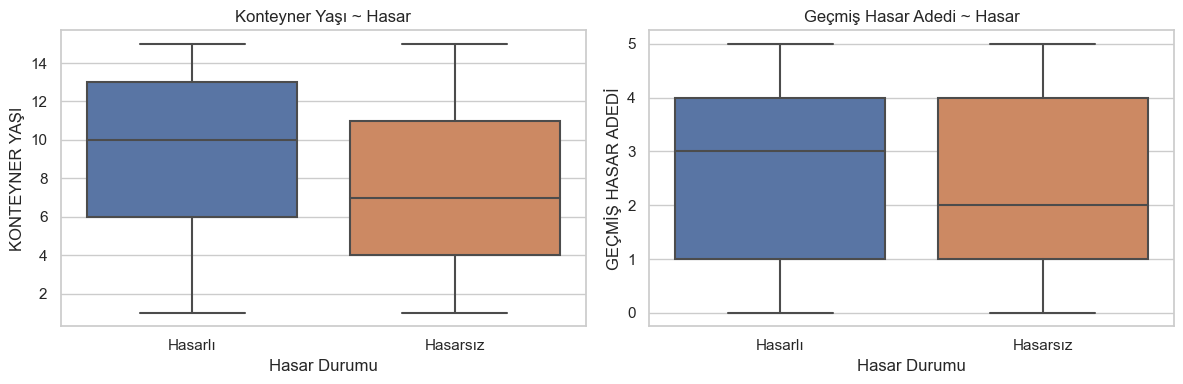

In [10]:
def rate_bar(cat_col, top=12):
    tmp = df[cat_col].value_counts().head(top).index
    g = df[df[cat_col].isin(tmp)].groupby(cat_col)["y_bin"].agg(["count","mean"]).sort_values("mean", ascending=False)
    ax = (g["mean"]*100).plot(kind="bar", figsize=(12,4), title=f"Hasarlı Oranı (%) — {cat_col}")
    plt.ylabel("% Hasarlı"); plt.xticks(rotation=45); plt.show()
    display(g.head(10))

rate_bar("MÜŞTERİ", top=15)
rate_bar("GOODS", top=15)
rate_bar("TAŞIMA ARACI", top=5)


fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(x="Hasar Durumu", y="KONTEYNER YAŞI", data=df, ax=axes[0])
axes[0].set_title("Konteyner Yaşı ~ Hasar")
sns.boxplot(x="Hasar Durumu", y="GEÇMİŞ HASAR ADEDİ", data=df, ax=axes[1])
axes[1].set_title("Geçmiş Hasar Adedi ~ Hasar")
plt.tight_layout(); plt.show()

### Dividing input variables and output variable Idle Return Time

In [11]:

X = df[["MÜŞTERİ","GOODS","KONTEYNER YAŞI","GEÇMİŞ HASAR ADEDİ","TAŞIMA ARACI"]].copy()
y = df["y_bin"].astype(int)

cat_cols = ["MÜŞTERİ","GOODS","TAŞIMA ARACI"]
num_cols = ["KONTEYNER YAŞI","GEÇMİŞ HASAR ADEDİ"]


try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        # ("num", "passthrough", num_cols)  # passthrough numeric
    ],
    remainder="passthrough"  # num kolonları direkt ekle
)

## Machine Learning Implementation

Baseline doğruluk (majority): 0.57
RandomForest: ACC=0.730 | P=0.682 | R=0.698 | F1=0.690 | ROC-AUC=0.790
HistGB: ACC=0.700 | P=0.651 | R=0.651 | F1=0.651 | ROC-AUC=0.770

En iyi model → RandomForest


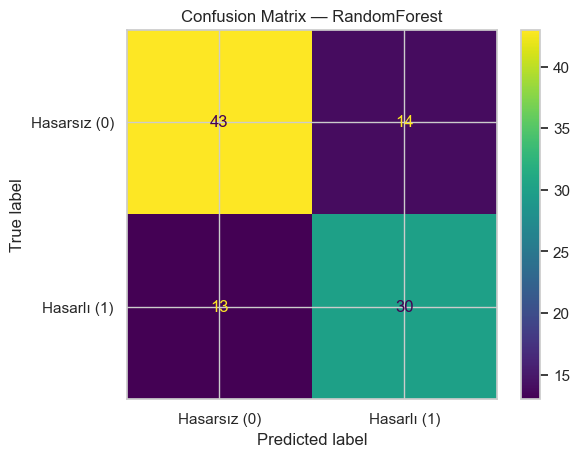

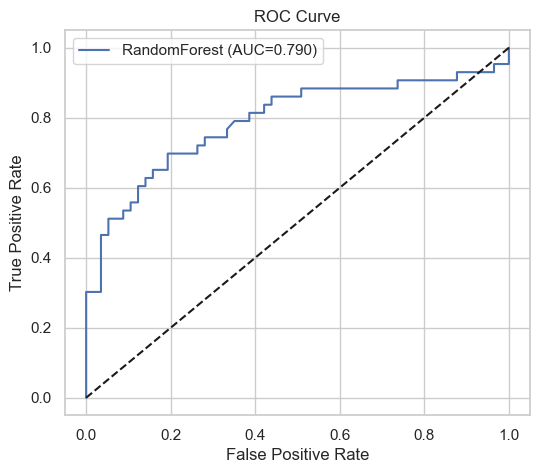

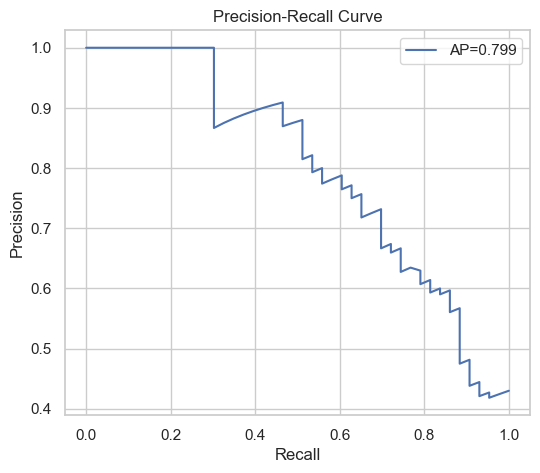

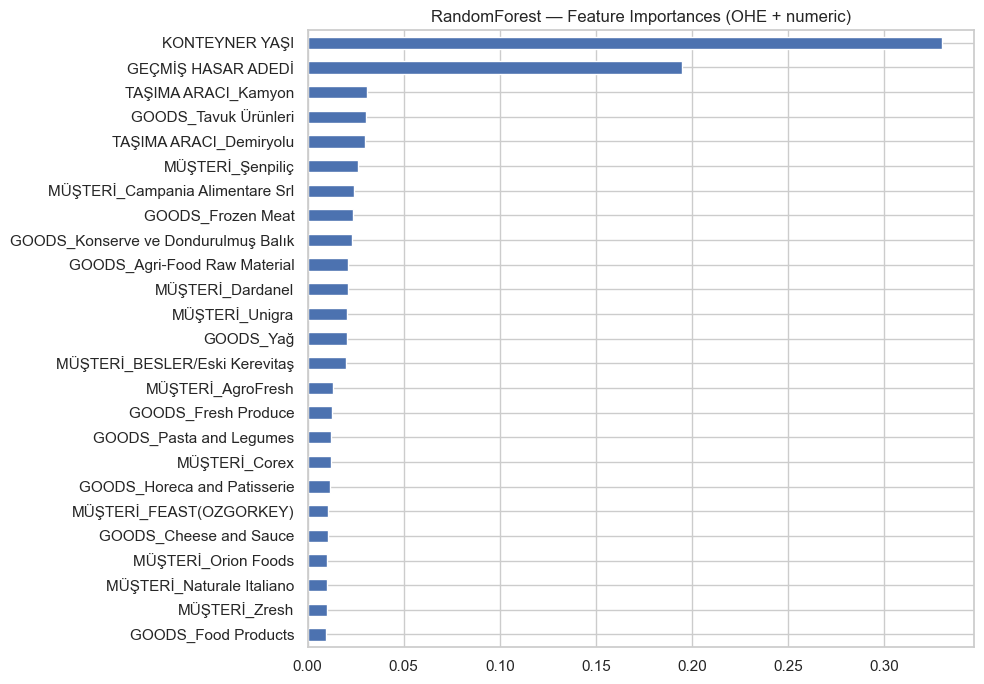

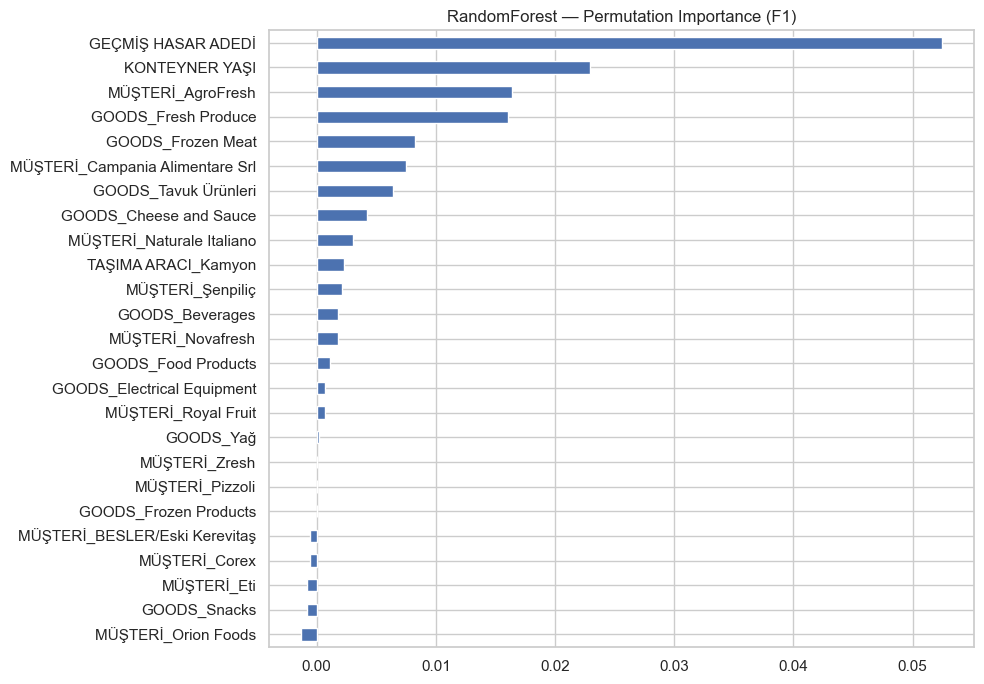

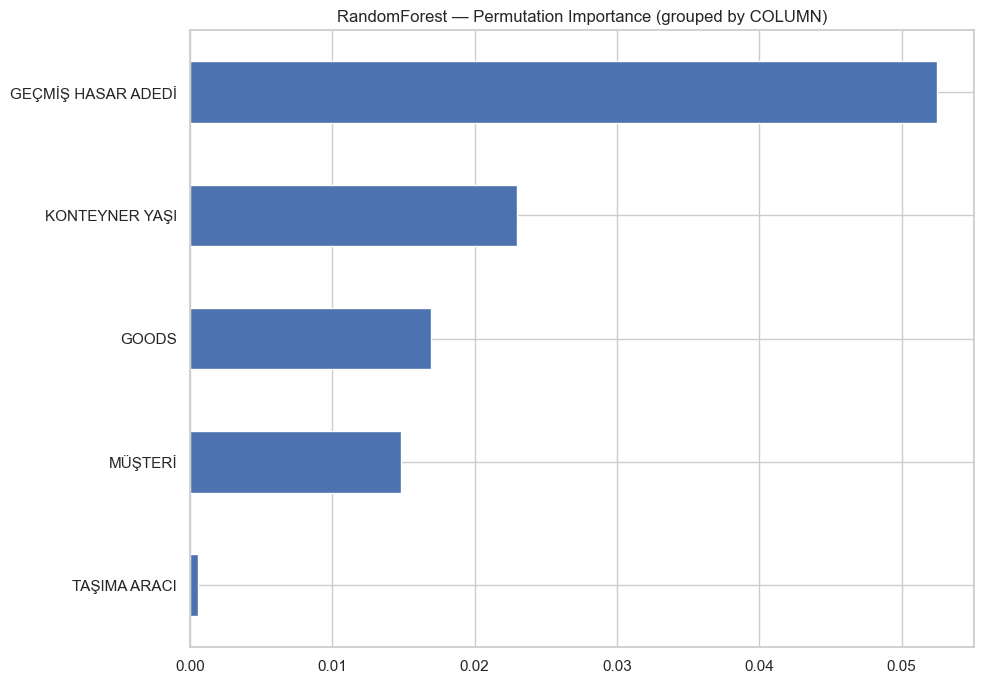

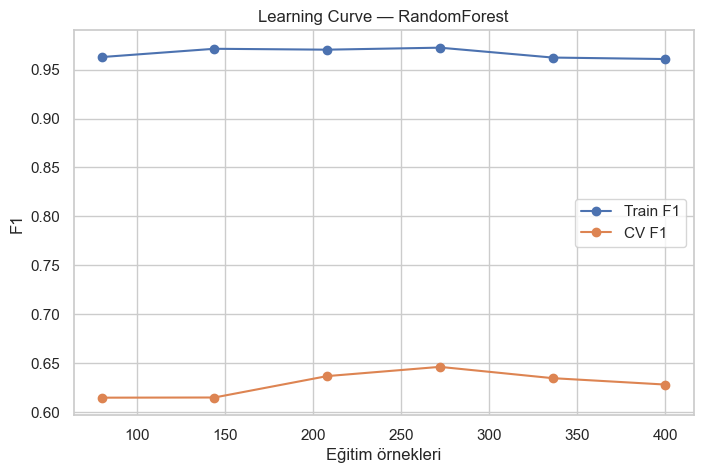

Kaydedildi → /Users/berilenbatan/hasar_durumu_predictions.xlsx


In [12]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train[[]], y_train)  # no features needed
y_base = dummy.predict(X_test[[]])
print("Baseline doğruluk (majority):", accuracy_score(y_test, y_base))



rf = RandomForestClassifier(
    n_estimators=600, max_depth=None, min_samples_split=3, min_samples_leaf=1,
    class_weight="balanced_subsample", random_state=42, n_jobs=-1
)
hgb = HistGradientBoostingClassifier(
    learning_rate=0.07, max_depth=None, max_iter=600, random_state=42
)

models = {
    "RandomForest": rf,
    "HistGB": hgb
}

def evaluate(name, model):
    pipe = Pipeline([("pre", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps["model"], "predict_proba") else pipe.decision_function(X_test)
    pred = (prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    f1  = f1_score(y_test, pred, zero_division=0)
    auc = roc_auc_score(y_test, prob)

    print(f"{name}: ACC={acc:.3f} | P={prec:.3f} | R={rec:.3f} | F1={f1:.3f} | ROC-AUC={auc:.3f}")
    return pipe, prob, pred

fitted = {}
probs  = {}
preds  = {}
for name, mdl in models.items():
    pipe, pr, pd_ = evaluate(name, mdl)
    fitted[name] = pipe; probs[name] = pr; preds[name] = pd_


best_name = max(models.keys(), key=lambda n: roc_auc_score(y_test, probs[n]))
best_pipe = fitted[best_name]
print(f"\nEn iyi model → {best_name}")


best_prob = probs[best_name]
best_pred = preds[best_name]


cm = confusion_matrix(y_test, best_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Hasarsız (0)","Hasarlı (1)"])
disp.plot(values_format="d"); plt.title(f"Confusion Matrix — {best_name}"); plt.show()


fpr, tpr, _ = roc_curve(y_test, best_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc_score(y_test, best_prob):.3f})")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()


prec, rec, _ = precision_recall_curve(y_test, best_prob)
ap = average_precision_score(y_test, best_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend(); plt.show()


ohe_fitted = best_pipe.named_steps["pre"].named_transformers_["cat"]
cat_names  = list(ohe_fitted.get_feature_names_out(cat_cols))
feature_names = cat_names + num_cols  # remainder passthrough order

def plot_importances(series, title, top=25):
    top_s = series.sort_values(ascending=False).head(top)
    plt.figure(figsize=(10,7))
    top_s.plot(kind="barh", title=title)
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

# A) Native importances (RF destekler)
if best_name == "RandomForest" and hasattr(best_pipe.named_steps["model"], "feature_importances_"):
    fi = pd.Series(best_pipe.named_steps["model"].feature_importances_, index=feature_names)
    plot_importances(fi, "RandomForest — Feature Importances (OHE + numeric)")

# B) Model-agnostic permutation importance (dense gerekli)
Xte_pre = best_pipe.named_steps["pre"].transform(X_test)
if hasattr(Xte_pre, "toarray"):  # just in case sparse appears
    Xte_pre = Xte_pre.toarray()

pi = permutation_importance(best_pipe.named_steps["model"], Xte_pre, y_test,
                            n_repeats=20, random_state=42, scoring="f1")
pi_series = pd.Series(pi.importances_mean, index=feature_names)
plot_importances(pi_series, f"{best_name} — Permutation Importance (F1)")

# Orijinal kolon isimlerine geri grupla (kategoriler bir araya)
grouped = {}
for k, v in pi_series.items():
    root = k.split("_")[0] if "_" in k else k  # MÜŞTERİ_Zresh -> MÜŞTERİ
    grouped[root] = grouped.get(root, 0.0) + v
plot_importances(pd.Series(grouped), f"{best_name} — Permutation Importance (grouped by COLUMN)", top=len(grouped))

# -----------------------------
# 7) Learning curve
# -----------------------------
train_sizes, train_scores, val_scores = learning_curve(
    best_pipe, X, y, cv=5, scoring="f1", train_sizes=np.linspace(0.2, 1.0, 6),
    shuffle=True, random_state=42
)
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train F1")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="CV F1")
plt.title(f"Learning Curve — {best_name}")
plt.xlabel("Eğitim örnekleri"); plt.ylabel("F1")
plt.legend(); plt.show()

# -----------------------------
# 8) Tüm satırlar için tahmin & dışa aktar
# -----------------------------
best_pipe.fit(X, y)
proba_all = best_pipe.predict_proba(X)[:,1]
pred_all  = (proba_all >= 0.5).astype(int)

out = df.copy()
out["PRED_HASARLI_PROB"] = np.round(proba_all, 4)
out["PRED_HASAR_DURUMU"] = np.where(pred_all==1, "Hasarlı", "Hasarsız")

OUT_XLSX = "hasar_durumu_predictions.xlsx"
out.drop(columns=["y_bin"]).to_excel(OUT_XLSX, index=False)
print("Kaydedildi →", os.path.abspath(OUT_XLSX))
